<a href="https://colab.research.google.com/github/git-chinmay/myML/blob/master/TFFlowerPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [0]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [6]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.2.0
Hub version:  0.8.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [8]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 3s 0us/step


In [9]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [10]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [11]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


In [12]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [14]:
# Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=5,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/5
92/92 [==============================] - 123s 1s/step - loss: 0.9256 - acc: 0.6516 - val_loss: 0.5058 - val_acc: 0.8208
Epoch 2/5
92/92 [==============================] - 123s 1s/step - loss: 0.4670 - acc: 0.8360 - val_loss: 0.4061 - val_acc: 0.8564
Epoch 3/5
92/92 [==============================] - 124s 1s/step - loss: 0.3994 - acc: 0.8557 - val_loss: 0.3620 - val_acc: 0.8714
Epoch 4/5
92/92 [==============================] - 124s 1s/step - loss: 0.3324 - acc: 0.8830 - val_loss: 0.3332 - val_acc: 0.8947
Epoch 5/5
92/92 [==============================] - 124s 1s/step - loss: 0.3004 - acc: 0.8918 - val_loss: 0.3344 - val_acc: 0.8728


In [15]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

23/23 [==============================] - 23s 1s/step - loss: 0.3422 - acc: 0.8796


In [16]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.34
Final accuracy: 87.96%


In [17]:
#Export the Model
FLOWERS_SAVED_MODEL = "saved_models/flowers3"
tf.saved_model.save(model, FLOWERS_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_models/flowers3/assets


INFO:tensorflow:Assets written to: saved_models/flowers3/assets


In [18]:
# Load SavedModel

flowers_model = hub.load(FLOWERS_SAVED_MODEL)
print(flowers_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f4461cd3208>


In [19]:
#Check Prediction on loaded model
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [20]:
#tf_model_predictions = flowers_model(val_image_batch)
tf_model_predictions = model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 5)


In [21]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Daisy,Dandelion,Roses,Sunflowers,Tulips
0,0.06114136,0.28701824,0.00331774,0.55140740,0.09711529
1,0.00001303,0.00003071,0.00454655,0.00008511,0.99532461
2,0.00018772,0.00001613,0.99927717,0.00002442,0.00049454
3,0.00561490,0.99240088,0.00026491,0.00091551,0.00080373
4,0.43116349,0.18403161,0.03416540,0.06093440,0.28970519


In [0]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

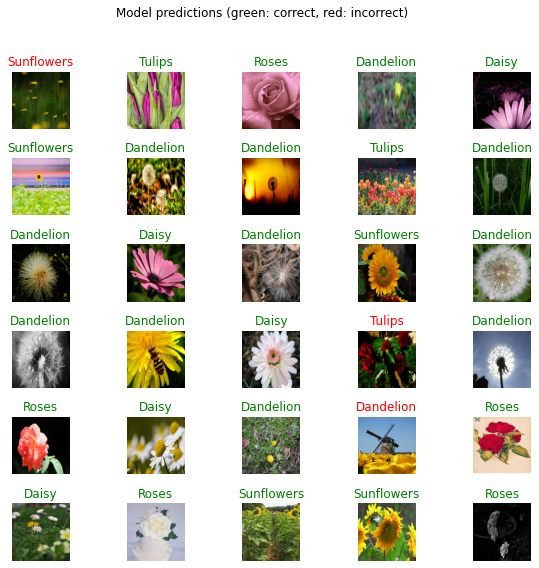

In [23]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")